## Example Notebook 

### Requirements

- nnfabrik, neuralpredictors, and nnvision from the sinzlab repository have to be installed/cloned

- we are using the pytorch image called `sinzlab/pytorch:v3.8-torch1.4.0-cuda10.1-dj0.12.4`
    - docker image can be found here: https://github.com/sinzlab/pytorch-docker or https://hub.docker.com/r/sinzlab/pytorch/dockerfile
    - there, the complete list of packages to be installed can be found.
    - torch >= 1.4 is required.
</br>
</br>
- All individual pickle files and the image-pickle file have to be present. The can be found on the GPU server under /var/lib/nova/sinz-shared/data


# Imports

make sure to install all required packages. dependencies are listed in the dockerfile above. If necessary, install packages within the environment


In [44]:
import torch

import nnfabrik
from nnfabrik import builder


import numpy as np
import pickle
import os

from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt

import nnvision

# NNfabrik intro: Using the builder to build the dataloader objects, models, trainer

In [3]:
# here's where the data is on the server:
os.listdir('/data')

['image_classification', 'monkey', 'mouse', 'fetched_from_attach']

In [4]:
#### loading monkey data

basepath = '/data/monkey/toliaslab/CSRF19_V1'
neuronal_data_path = os.path.join(basepath, 'neuronal_data/')
neuronal_data_files = [neuronal_data_path+f for f in listdir(neuronal_data_path) if isfile(join(neuronal_data_path, f))]
image_file = os.path.join(basepath, 'images/CSRF19_V1_images.pickle')
image_cache_path = os.path.join(basepath, 'images/individual')


In [5]:
# Specifying the dataset function: its defined in nnvision/datasets, and has to present in the __init__.py there.
dataset_fn = 'nnvision.datasets.monkey_static_loader'
dataset_config = dict(dataset='CSRF19_V1',
                               neuronal_data_files=neuronal_data_files,
                               image_cache_path=image_cache_path,
                               crop=102,
                               subsample=1,
                               seed=1000,
                               time_bins_sum=6,
                               batch_size=128,)


In [6]:
dataloaders = builder.get_data(dataset_fn, dataset_config)

## Dataloaders

NNfabrik expects dataloaders to be nested dictionarys with actual PyTorch DataLoader Objects at the second Tier. The First Tier will be "train", "validation", and "test". The second Tier will be "session_key": DataLoader. So each dataset is either comprised of one or multiple sessions, with a session ID as the dictionary key to its dataloader.
Let's have a look:

In [7]:
dataloaders

{'train': {'3636552742293': <torch.utils.data.dataloader.DataLoader at 0x7f09c3fdb7c0>,
  '3636034866307': <torch.utils.data.dataloader.DataLoader at 0x7f08cc0ab820>,
  '3635178040531': <torch.utils.data.dataloader.DataLoader at 0x7f0990055ac0>,
  '3637851724731': <torch.utils.data.dataloader.DataLoader at 0x7f099005a970>,
  '3638973674012': <torch.utils.data.dataloader.DataLoader at 0x7f099005b940>,
  '3637248451650': <torch.utils.data.dataloader.DataLoader at 0x7f0990060700>,
  '3638885582960': <torch.utils.data.dataloader.DataLoader at 0x7f09900625e0>,
  '3638373332053': <torch.utils.data.dataloader.DataLoader at 0x7f098ffe84c0>,
  '3638541006102': <torch.utils.data.dataloader.DataLoader at 0x7f098ffec460>,
  '3633364677437': <torch.utils.data.dataloader.DataLoader at 0x7f098fff1250>,
  '3640011636703': <torch.utils.data.dataloader.DataLoader at 0x7f098fff3130>,
  '3631807112901': <torch.utils.data.dataloader.DataLoader at 0x7f098fff8100>,
  '3639664527524': <torch.utils.data.datalo

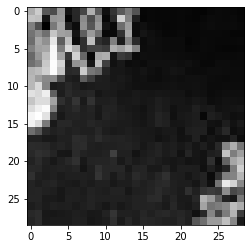

In [8]:
# here's a random image. The images are cropped to be 20x20, so it trains fast for demo purposes.
some_image = dataloaders["train"][list(dataloaders["train"].keys())[0]].dataset[:].inputs[0,0,::].cpu().numpy()
plt.imshow(some_image, cmap='gray')

In [9]:
# get first data_key
first_session_ID = list((dataloaders["train"].keys()))[0]


In [10]:
a_dataloader = dataloaders["train"][first_session_ID]
a_dataloader

In [11]:
inputs, targets = next(iter(a_dataloader))
print("image_dimensions:", inputs.shape)
print("number of neurons of that session: ", targets.shape)
print("total training batches: ", len(a_dataloader))

image_dimensions: torch.Size([128, 1, 29, 29])
number of neurons of that session:  torch.Size([128, 24])
total training batches:  77


In [12]:
# input image dimension
input_shape = dataloaders["train"][first_session_ID].dataset[:].inputs.shape
print(input_shape)
# total images = 16064
# dims: N x C x W x H

torch.Size([9803, 1, 29, 29])


In [13]:
# outpt dimensions: neuronal firing rates'
output_shape = dataloaders["train"][first_session_ID].dataset[:].targets.shape

print(output_shape)
# Output: 14 Neurons, with N spikes over 60 ms

torch.Size([9803, 24])


## Model Building

Models are built using the neuralpredictors repo from sinzlab. They consist of a convolutional core (with a user-specified number of layers), and a readout (spatial transformer readout, described in Sinz et al, 2018, NeurIPS).

### Building a model

In [45]:

model_fn = 'nnvision.models.se_core_full_gauss_readout'
model_config = {'pad_input': False,
                'stack': -1,
               'depth_separable': True,
               'input_kern': 20,
               'gamma_input': 11.2,
               'gamma_readout': 0.33,
               'hidden_dilation': 1,
               'hidden_kern': 5,
               'n_se_blocks': 0,
               'hidden_channels': 32}
model = builder.get_model(model_fn, model_config, dataloaders=dataloaders,seed=1000)
print(model)

Encoder(
  (core): SE2dCore(
    (_input_weights_regularizer): LaplaceL2norm(
      (laplace): Laplace()
    )
    (features): Sequential(
      (layer0): Sequential(
        (conv): Conv2d(1, 32, kernel_size=(20, 20), stride=(1, 1), bias=False)
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (layer1): Sequential(
        (ds_conv): DepthSeparableConv2d(
          (in_depth_conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (spatial_conv): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=32, bias=False)
          (out_depth_conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (layer2): Sequential(
        (ds_conv): DepthSeparableConv2d(
          

Above is the model description. Each session has its own readout. The Readout learns an x,y position between -1 and 1, relative to image space, and reads out from that point in feature space. THat means that the effective receptive field size of a unit in the last hidden layer will also be the receptive field size of the neuron. The x/y coordinates can be accessed like this:


#### Show example readout positions after initialization

In [15]:
# x/y position (after random initialization, becuse the model isnt trained yet) for each neuron in that session
model.readout[first_session_ID].grid

tensor([[[[-0.1017, -0.1422]],

         [[ 0.1074, -0.0624]],

         [[-0.0140, -0.1852]],

         [[-0.0939,  0.1339]],

         [[ 0.1270, -0.0854]],

         [[ 0.0903, -0.1766]],

         [[ 0.1376, -0.0156]],

         [[-0.0767,  0.1409]],

         [[ 0.1300,  0.0866]],

         [[ 0.0717,  0.1135]],

         [[-0.0119, -0.1061]],

         [[ 0.1604, -0.0997]],

         [[ 0.0196, -0.1664]],

         [[ 0.0189,  0.1813]],

         [[-0.1017,  0.0104]],

         [[ 0.1327,  0.0214]],

         [[-0.0400, -0.1720]],

         [[-0.1821,  0.0498]],

         [[ 0.0327, -0.1954]],

         [[-0.1747,  0.0716]],

         [[ 0.1302,  0.1117]],

         [[-0.1723,  0.0734]],

         [[ 0.0086, -0.0570]],

         [[-0.1747, -0.0322]]]], grad_fn=<ClampBackward>)

## Building a Trainer

the trainer is taking care of the whole training process. when the trainer is built, itÄ's a function with the configuration already initialized

In [16]:
trainer_fn = 'nnvision.training.nnvision_trainer'
trainer_config = dict(max_iter=1, 
                      lr_decay_steps=4, 
                      tolerance=0.0005, 
                      patience=5,
                      verbose=False, 
                      lr_init=0.003,
                      avg_loss=False,
                      device='cuda')

trainer = builder.get_trainer(trainer_fn, trainer_config)

## Train a model

In [23]:
score, output, model_state = trainer(model=model, dataloaders=dataloaders, seed=1000)

Epoch 1: 100%|██████████| 3616/3616 [00:42<00:00, 85.33it/s] 


[001|00/05] ---> 0.21615184843540192
Restoring best model! 0.216152 ---> 0.216152


# Part Two: NNfabrik and DataJoint

Instead of using the builder to get the data/model/and trainer, we can use datajoint to manage that process for us.
There are Model, Dataset, and Trainer Tables. And each combination in those tables should in principle lead to a fully trained model.
For completeness, there is also a Seed table that stores the random seed, and a Fabrikant table, that stores the name and contact details of the creator (=Fabrikant).


### Make sure that a dj-database is connected. Recommended dj version is 0.12.4

In [46]:
import datajoint as dj

dj.config['enable_python_native_blobs'] = True
dj.config['nnfabrik.schema_name'] = "pawelp_playground"
schema = dj.schema("pawelp_playground")

from nnfabrik.templates import TrainedModelBase
from nnfabrik.main import *

schema

Schema `pawelp_playground`

In [17]:
# change this entry to reflect your datajoint username
Fabrikant().insert1(dict(fabrikant_name='pawelp',
                         email="ppierzc@gmail.com",
                         affiliation='sinzlab',
                         dj_username="pawelp"))

In [18]:
Fabrikant()

fabrikant_name Name of the contributor that added this entry,full_name full name of the person,email e-mail address,affiliation conributor's affiliation (e.g. Sinz Lab),dj_username DataJoint username
pawelp,,ppierzc@gmail.com,sinzlab,pawelp


In [19]:
Seed().insert([{'seed':1000}])
Seed()

seed Random seed that is passed to the model- and dataset-builder
1000


###  add entries for dataset, model, and trainer, with their corresponding configurations

#### Dataset

In [20]:
# adds the dataset_function and dataset config that we defined above to the datase table
Dataset().add_entry(dataset_fn, dataset_config, dataset_comment='CSRF_V1')
Dataset()

dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,dataset_config dataset configuration object,dataset_fabrikant Name of the contributor that added this entry,dataset_comment short description,dataset_ts UTZ timestamp at time of insertion
nnvision.datasets.monkey_static_loader,b13210feedc7c9d926c489f5774193b9,=BLOB=,pawelp,CSRF_V1,2020-11-19 16:17:39


#### Model

In [21]:
model_fn = 'nnvision.models.se_core_full_gauss_readout'
model_config = {'pad_input': False,
                'stack': -1,
               'depth_separable': True,
               'input_kern': 20,
               'gamma_input': 11.2,
               'gamma_readout': 0.33,
               'hidden_dilation': 1,
               'hidden_kern': 5,
               'n_se_blocks': 0,
               'hidden_channels': 32,
               'gauss_type': 'isotropic'}                
Model().add_entry(model_fn, model_config, model_comment='isotropic')
Model()

model_fn name of the model function,model_hash hash of the model configuration,model_config model configuration to be passed into the function,model_fabrikant Name of the contributor that added this entry,model_comment short description,model_ts UTZ timestamp at time of insertion
nnvision.models.se_core_full_gauss_readout,a08c72eb2972056853de6f1ce881e0f0,=BLOB=,pawelp,isotropic,2020-11-19 16:17:41


In [22]:
Trainer.delete()

About to delete:
Nothing to delete


In [23]:
trainer_fn = 'nnvision.training.nnvision_trainer'
trainer_config = dict(max_iter=2, 
                      lr_decay_steps=4, 
                      tolerance=0.0005, 
                      patience=5,
                      verbose=False, 
                      lr_init=0.0045,
                      avg_loss=False,
                      device='cuda')

Trainer().add_entry(trainer_fn, trainer_config, trainer_comment="max_iter: 2")
Trainer()

trainer_fn name of the Trainer loader function,trainer_hash hash of the configuration object,trainer_config training configuration object,trainer_fabrikant Name of the contributor that added this entry,trainer_comment short description,trainer_ts UTZ timestamp at time of insertion
nnvision.training.nnvision_trainer,e225a557fe8039df3717ddbe4686caa9,=BLOB=,pawelp,max_iter: 2,2020-11-19 16:17:48


In [24]:
(Trainer & "trainer_hash='e225a557fe8039df3717ddbe4686caa9'")

trainer_fn name of the Trainer loader function,trainer_hash hash of the configuration object,trainer_config training configuration object,trainer_fabrikant Name of the contributor that added this entry,trainer_comment short description,trainer_ts UTZ timestamp at time of insertion
nnvision.training.nnvision_trainer,e225a557fe8039df3717ddbe4686caa9,=BLOB=,pawelp,max_iter: 2,2020-11-19 16:17:48


####  The TrainedModel is a template, which can be found in nnfabrik.template.py

the trained model table is taking care of model training, and stores the model state in a part table. For further analyses of the trained model, one can either overwrite the TrainedModel definition by inheriting from the Base template class, or by attaching other tables to trained model.

In [25]:
# creating the simples TrainedModel class
@schema
class TrainedModel(TrainedModelBase):
    table_comment = "Trained models"

    model_table = Model
    dataset_table = Dataset
    trainer_table = Trainer
    seed_table = Seed
    user_table = Fabrikant

In [26]:
TrainedModel()

model_fn name of the model function,model_hash hash of the model configuration,dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,trainer_fn name of the Trainer loader function,trainer_hash hash of the configuration object,seed Random seed that is passed to the model- and dataset-builder,comment short description,score loss,output trainer object's output,fabrikant_name Name of the contributor that added this entry,trainedmodel_ts UTZ timestamp at time of insertion


as primary keys, it has the hashes of all the configurations, and it stores the score, and the output (which are defined in the respective trainer)

## Lets populate

In [28]:
TrainedModel().populate()

Epoch 1: 100%|██████████| 3616/3616 [00:46<00:00, 78.46it/s] 


[001|00/05] ---> 0.22903917729854584


Epoch 2: 100%|██████████| 3616/3616 [00:37<00:00, 95.96it/s] 


[002|00/05] ---> 0.26305264234542847
Restoring best model! 0.263053 ---> 0.263053


In [29]:
TrainedModel()

model_fn name of the model function,model_hash hash of the model configuration,dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,trainer_fn name of the Trainer loader function,trainer_hash hash of the configuration object,seed Random seed that is passed to the model- and dataset-builder,comment short description,score loss,output trainer object's output,fabrikant_name Name of the contributor that added this entry,trainedmodel_ts UTZ timestamp at time of insertion
nnvision.models.se_core_full_gauss_readout,a08c72eb2972056853de6f1ce881e0f0,nnvision.datasets.monkey_static_loader,b13210feedc7c9d926c489f5774193b9,nnvision.training.nnvision_trainer,e225a557fe8039df3717ddbe4686caa9,1000,max_iter: 2.isotropic.CSRF_V1,0.263053,=BLOB=,pawelp,2020-11-19 16:20:52


In [30]:
model_hash = TrainedModel().fetch1("model_hash")

In [31]:
# now if you want to build the model again, we can use the .load_model() function of the trained model table.
# To use the load model function, the table needs to be restricted to one Entry. 
# for example: restricting with a key:
some_key = dict(model_hash=model_hash)
TrainedModel&some_key

model_fn name of the model function,model_hash hash of the model configuration,dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,trainer_fn name of the Trainer loader function,trainer_hash hash of the configuration object,seed Random seed that is passed to the model- and dataset-builder,comment short description,score loss,output trainer object's output,fabrikant_name Name of the contributor that added this entry,trainedmodel_ts UTZ timestamp at time of insertion
nnvision.models.se_core_full_gauss_readout,a08c72eb2972056853de6f1ce881e0f0,nnvision.datasets.monkey_static_loader,b13210feedc7c9d926c489f5774193b9,nnvision.training.nnvision_trainer,e225a557fe8039df3717ddbe4686caa9,1000,max_iter: 2.isotropic.CSRF_V1,0.263053,=BLOB=,pawelp,2020-11-19 16:20:52


# How to Load a Model

In [32]:
dataloader, model = (TrainedModel & some_key).load_model()

In [33]:
# that is the trained model, with the state dict loaded and all. lets set to eval and start using it
model.eval()

Encoder(
  (core): SE2dCore(
    (_input_weights_regularizer): LaplaceL2norm(
      (laplace): Laplace()
    )
    (features): Sequential(
      (layer0): Sequential(
        (conv): Conv2d(1, 32, kernel_size=(20, 20), stride=(1, 1), bias=False)
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (layer1): Sequential(
        (ds_conv): DepthSeparableConv2d(
          (in_depth_conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (spatial_conv): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=32, bias=False)
          (out_depth_conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (layer2): Sequential(
        (ds_conv): DepthSeparableConv2d(
          

# Parameter Extension

In [34]:
# There's also the parameter extension, so that you can restrict with the confif objects as well.

In [35]:
from nnfabrik.utility.dj_helpers import create_param_expansion, make_definition
ModelExpanded = create_param_expansion('nnvision.models.se_core_full_gauss_readout', Model, fn_field='model_fn', config_field='model_config')
ModelParams = schema(ModelExpanded)

In [36]:
ModelParams()

model_fn name of the model function,model_hash hash of the model configuration,hidden_channels autogenerated column - int,input_kern autogenerated column - int,hidden_kern autogenerated column - int,layers autogenerated column - int,gamma_input autogenerated column - float,skip autogenerated column - int,final_nonlinearity autogenerated column - bool,momentum autogenerated column - float,pad_input autogenerated column - bool,batch_norm autogenerated column - bool,hidden_dilation autogenerated column - int,laplace_padding autogenerated column - longblob,input_regularizer autogenerated column - varchar(255),init_mu_range autogenerated column - float,init_sigma autogenerated column - float,readout_bias autogenerated column - bool,gamma_readout autogenerated column - int,elu_offset autogenerated column - int,stack autogenerated column - longblob,se_reduction autogenerated column - int,n_se_blocks autogenerated column - int,depth_separable autogenerated column - bool,linear autogenerated column - bool,gauss_type autogenerated column - varchar(255),grid_mean_predictor autogenerated column - longblob,share_features autogenerated column - bool,share_grid autogenerated column - bool,data_info autogenerated column - longblob,gamma_grid_dispersion autogenerated column - int,attention_conv autogenerated column - bool


In [37]:
ModelParams.populate()

In [38]:
ModelParams()

model_fn name of the model function,model_hash hash of the model configuration,hidden_channels autogenerated column - int,input_kern autogenerated column - int,hidden_kern autogenerated column - int,layers autogenerated column - int,gamma_input autogenerated column - float,skip autogenerated column - int,final_nonlinearity autogenerated column - bool,momentum autogenerated column - float,pad_input autogenerated column - bool,batch_norm autogenerated column - bool,hidden_dilation autogenerated column - int,laplace_padding autogenerated column - longblob,input_regularizer autogenerated column - varchar(255),init_mu_range autogenerated column - float,init_sigma autogenerated column - float,readout_bias autogenerated column - bool,gamma_readout autogenerated column - int,elu_offset autogenerated column - int,stack autogenerated column - longblob,se_reduction autogenerated column - int,n_se_blocks autogenerated column - int,depth_separable autogenerated column - bool,linear autogenerated column - bool,gauss_type autogenerated column - varchar(255),grid_mean_predictor autogenerated column - longblob,share_features autogenerated column - bool,share_grid autogenerated column - bool,data_info autogenerated column - longblob,gamma_grid_dispersion autogenerated column - int,attention_conv autogenerated column - bool
nnvision.models.se_core_full_gauss_readout,a08c72eb2972056853de6f1ce881e0f0,32,20,5,3,11.2,0,1,0.9,0,1,1,=BLOB=,LaplaceL2norm,0.2,1.0,1,0,0,=BLOB=,32,0,1,0,isotropic,=BLOB=,0,0,=BLOB=,0,0


In [47]:
# for example:
TrainedModel*ModelParams&"hidden_kern=5"

model_fn name of the model function,model_hash hash of the model configuration,dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,trainer_fn name of the Trainer loader function,trainer_hash hash of the configuration object,seed Random seed that is passed to the model- and dataset-builder,comment short description,score loss,output trainer object's output,fabrikant_name Name of the contributor that added this entry,trainedmodel_ts UTZ timestamp at time of insertion,hidden_channels autogenerated column - int,input_kern autogenerated column - int,hidden_kern autogenerated column - int,layers autogenerated column - int,gamma_input autogenerated column - float,skip autogenerated column - int,final_nonlinearity autogenerated column - bool,momentum autogenerated column - float,pad_input autogenerated column - bool,batch_norm autogenerated column - bool,hidden_dilation autogenerated column - int,laplace_padding autogenerated column - longblob,input_regularizer autogenerated column - varchar(255),init_mu_range autogenerated column - float,init_sigma autogenerated column - float,readout_bias autogenerated column - bool,gamma_readout autogenerated column - int,elu_offset autogenerated column - int,stack autogenerated column - longblob,se_reduction autogenerated column - int,n_se_blocks autogenerated column - int,depth_separable autogenerated column - bool,linear autogenerated column - bool,gauss_type autogenerated column - varchar(255),grid_mean_predictor autogenerated column - longblob,share_features autogenerated column - bool,share_grid autogenerated column - bool,data_info autogenerated column - longblob,gamma_grid_dispersion autogenerated column - int,attention_conv autogenerated column - bool
nnvision.models.se_core_full_gauss_readout,a08c72eb2972056853de6f1ce881e0f0,nnvision.datasets.monkey_static_loader,b13210feedc7c9d926c489f5774193b9,nnvision.training.nnvision_trainer,e225a557fe8039df3717ddbe4686caa9,1000,max_iter: 2.isotropic.CSRF_V1,0.263053,=BLOB=,pawelp,2020-11-19 16:20:52,32,20,5,3,11.2,0,1,0.9,0,1,1,=BLOB=,LaplaceL2norm,0.2,1.0,1,0,0,=BLOB=,32,0,1,0,isotropic,=BLOB=,0,0,=BLOB=,0,0


In [48]:
# Now you can just use that for building the model:
dataloaders, model = (TrainedModel*ModelParams&"hidden_kern=5").load_model()

AttributeError: 'Join' object has no attribute 'load_model'

### Training New Model

In [52]:
model_key = [{'model_fn': 'nnvision.models.se_core_point_readout',
  'model_hash': 'f8bcd882c48a55dc6cd6d7afb656f1f9',
  'dataset_fn': 'nnvision.datasets.monkey_static_loader',
  'dataset_hash': 'a737408da40cfedd036c2eb1b8a31ff1',
  'trainer_fn': 'nnvision.training.nnvision_trainer',
  'trainer_hash': '2a2816c50c67295376b4e89448430985',
  'seed': 2000,
  'ensemble_hash': 'e7a8d0b961ee37ffda0779bfed95f1cf'}]

model_config = TrainedModel().get_full_config(model_key, include_trainer=False, include_state_dict=False)

DataJointError: fetch1 should only return one tuple. 0 tuples were found

In [ ]:
model_fn = 'nnvision.models.se_core_full_gauss_readout'
model_config = {'pad_input': False,
                'stack': -1,
               'depth_separable': True,
               'input_kern': 20,
               'gamma_input': 11.2,
               'gamma_readout': 0.33,
               'hidden_dilation': 1,
               'hidden_kern': 5,
               'n_se_blocks': 0,
               'hidden_channels': 32}
model = builder.get_model(model_fn, model_config, dataloaders=dataloaders,seed=1000)
print(model)